# Simple Linear Model
> Work demonestrated below is based on [Simple Linear Model](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/01_Simple_Linear_Model.ipynb)

![Tensorflow Linear Model Graph](images/tf-linear-model-graph.png)

## Imports

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [60]:
tf.__version__

'1.3.0'

## Load Data
The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [61]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70.000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [62]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## One-Hot Encoding¶
The data-set has been loaded as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [63]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. Note that the word 'class' is a keyword used in Python so we need to use the name 'cls' instead.

In [64]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [65]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

## Data dimensions
The data dimensions are used in several places in the source-code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. This means the numbers only have to be changed in one single place. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

In [66]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Plot a few images to see if data is correct

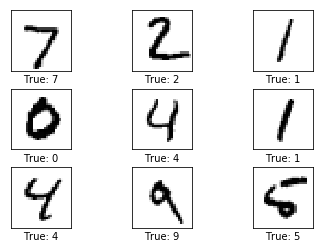

In [67]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Constructing TensorFlow Graph
A TensorFlow graph consists of the following parts which will be detailed below:
- Placeholder variables used to change the input to the graph.
- Model variables that are going to be optimized so as to make the model perform better.
- The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables of the model.

### Placeholder variables

In [68]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [69]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [70]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

In [71]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [72]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [73]:
logits = tf.matmul(x, weights) + biases

In [74]:
y_pred = tf.nn.softmax(logits)

In [75]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

In [76]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

In [77]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method

In [78]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance measures

In [79]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [80]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [81]:
global session
session = tf.Session()

### Initialize variables¶
The variables for weights and biases must be initialized before we start optimizing them.

In [82]:
session.run(tf.global_variables_initializer())

### Iterations
There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [83]:
batch_size = 100

### Testing Dict

In [84]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

## Helper Functions

In [85]:
#Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
# Function for performing a number of optimization iterations so as to gradually improve the weights and biases of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
# Function for printing the classification accuracy on the test-set.
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    
# Function for printing and plotting the confusion matrix using scikit-learn.
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
# Function for plotting examples of images from the test-set that have been mis-classified.
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
    
 # Function for plotting the weights of the model. 10 images are plotted, one for each digit that the model is trained to recognize.
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])


## Performance before any optimization
The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [86]:
print_accuracy()

Accuracy on test-set: 9.8%


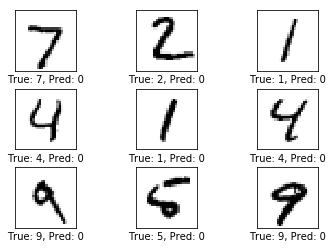

In [87]:
plot_example_errors()

## Performance after 1 optimization iteration

In [88]:
optimize(num_iterations=1)

In [89]:
print_accuracy()

Accuracy on test-set: 48.0%


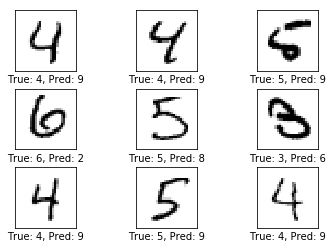

In [90]:
plot_example_errors()

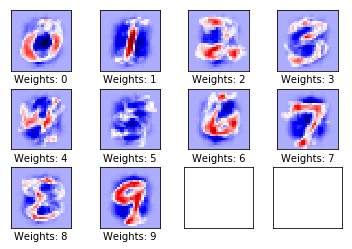

In [91]:
plot_weights()

## Performance after 10 optimization iterations

In [92]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [93]:
print_accuracy()

Accuracy on test-set: 79.9%


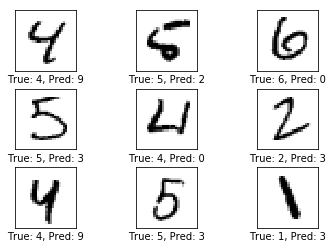

In [94]:
plot_example_errors()

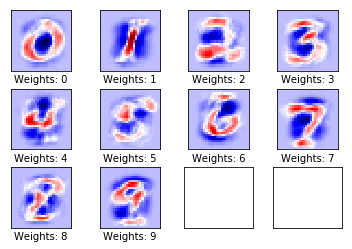

In [95]:
plot_weights()

## Performance after 1000 optimization iterations

In [96]:
optimize(num_iterations=990)

In [97]:
print_accuracy()

Accuracy on test-set: 91.9%


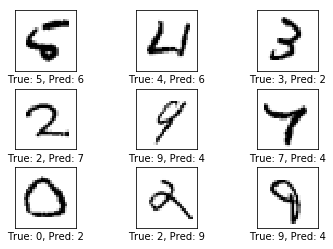

In [98]:
plot_example_errors()

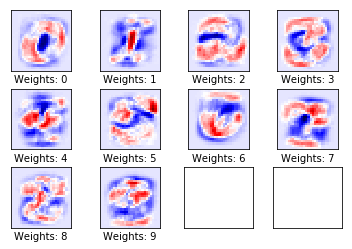

In [99]:
plot_weights()

[[ 946    0    6    2    0    9   11    3    3    0]
 [   0 1106    2    2    0    2    4    2   17    0]
 [   4    6  931   10   15    2    9   10   39    6]
 [   3    1   31  911    1   24    2    9   19    9]
 [   1    2    5    1  927    0   10    2    7   27]
 [   8    3    7   41   14  744   17    7   43    8]
 [   8    3    3    2   13   13  912    1    3    0]
 [   2    7   28    7    9    0    0  938    1   36]
 [   6    8    9   20    9   18   11   11  871   11]
 [   9    6    2    9   47    4    0   20    9  903]]


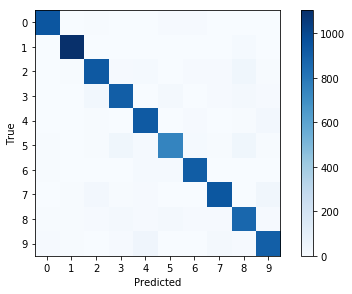

In [100]:
print_confusion_matrix()

## The End

In [101]:
session.close()